<a href="https://colab.research.google.com/github/ballmdr/Forex-Prediction-Machine_Learning/blob/master/Feature_Engineering_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and preprocess data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def create_multivariate_rnn_data(x, y, window_size):
    y = y[window_size:]
    n = x.shape[0]
    x = np.stack([x[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return x, y

def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)
  
def create_sequence(data, past=1, future=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(past, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, future):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    return agg

In [4]:
filename = '/content/drive/My Drive/export/M30_all_EURUSD.csv'
df = pd.read_csv(filename, names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)
df.set_index('Datetime', inplace=True)

# Features for Momentum Strategy
df['Returns'] = - df.Close.pct_change(-1)

df['MA35'] = df.Close.rolling(35).mean()
df['MA70'] = df.Close.rolling(70).mean()
df['MA200'] = df.Close.rolling(200).mean()

# ma35 > ma70 = bullish
df['35_70'] = np.where(df.MA35 >= df.MA70, 1, 0)

# price > ma200 = bullish
df['bias_trend'] = np.where(df.Close.values >= df.MA200, 1, 0) 

df['body_candles'] = df.Open - df.Close
df['high_low'] = df.High - df.Low

df.dropna(inplace=True)

def norm_features(x):
  return (x - x.mean()) / (x.max() - x.min())



# normalize
df['Returns'] = norm_features(df.Returns)
df['Volume'] = norm_features(df.Volume)
df['body_candles'] = norm_features(df.body_candles)
df['high_low'] = norm_features(df.high_low)

df['Target'] = np.ones((len(df)))
df['Target'].loc[df.Returns > df.Returns.quantile(.80)] = 2
df['Target'].loc[df.Returns < df.Returns.quantile(.20)] = 0





/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
df_ma = df[['MA35', 'MA70', 'MA200']]

In [8]:
df_ma.head()

,MA35,MA70,MA200
Datetime,,,
2003-08-08 03:30:00,1.136986,1.135372,1.134885
2003-08-08 04:00:00,1.136997,1.135369,1.134927
2003-08-08 04:30:00,1.136987,1.135405,1.134974
2003-08-08 05:00:00,1.137005,1.135444,1.135022
2003-08-08 05:30:00,1.137009,1.135478,1.135073


In [0]:
past = 8
new_df = create_sequence(df_ma.values, past, 1, feat_name=df_ma.columns)

In [0]:
new_df = new_df.set_index(df.index)
df = pd.concat([df, new_df], axis=1)

In [39]:
df.head()

,Date,Time,Open,High,Low,Close,Volume,Returns,MA35,MA70,MA200,35_70,bias_trend,body_candles,high_low,Target,MA35(t-8),MA70(t-8),MA200(t-8),MA35(t-7),MA70(t-7),MA200(t-7),MA35(t-6),MA70(t-6),MA200(t-6),MA35(t-5),MA70(t-5),MA200(t-5),MA35(t-4),MA70(t-4),MA200(t-4),MA35(t-3),MA70(t-3),MA200(t-3),MA35(t-2),MA70(t-2),MA200(t-2),MA35(t-1),MA70(t-1),MA200(t-1),MA35(t),MA70(t),MA200(t)
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-08-08 03:30:00,2003.08.08,03:30,1.13551,1.13616,1.13524,1.13556,0.004896,-0.001861,1.136986,1.135372,1.134885,1,1,-0.001086,-0.024926,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136986,1.135372,1.134885
2003-08-08 04:00:00,2003.08.08,04:00,1.13563,1.13573,1.13504,1.13549,0.006421,0.009104,1.136997,1.135369,1.134927,1,1,0.003343,-0.034264,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136986,1.135372,1.134885,1.136997,1.135369,1.134927
2003-08-08 04:30:00,2003.08.08,04:30,1.13544,1.13603,1.13524,1.13583,0.002527,0.003220,1.136987,1.135405,1.134974,1,1,-0.009012,-0.030204,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136986,1.135372,1.134885,1.136997,1.135369,1.134927,1.136987,1.135405,1.134974
2003-08-08 05:00:00,2003.08.08,05:00,1.13578,1.13664,1.13578,1.13595,0.001951,0.013910,1.137005,1.135444,1.135022,1,1,-0.003883,-0.027362,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136986,1.135372,1.134885,1.136997,1.135369,1.134927,1.136987,1.135405,1.134974,1.137005,1.135444,1.135022
2003-08-08 05:30:00,2003.08.08,05:30,1.13599,1.13654,1.13546,1.13647,0.001769,0.008295,1.137009,1.135478,1.135073,1,1,-0.011109,-0.018430,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.136986,1.135372,1.134885,1.136997,1.135369,1.134927,1.136987,1.135405,1.134974,1.137005,1.135444,1.135022,1.137009,1.135478,1.135073


In [0]:
df.drop(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Returns', 'MA35', 'MA70', 'MA200'], axis=1, inplace=True)

X = df.drop('Target', axis=1).values
Y = df.Target.values

# convert y into categorical
for i in range(len(Y)):
  print()

In [0]:
Y

Datetime
2003-08-08 03:30:00    1.0
2003-08-08 04:00:00    1.0
2003-08-08 04:30:00    1.0
2003-08-08 05:00:00    1.0
2003-08-08 05:30:00    1.0
2003-08-08 06:00:00    1.0
2003-08-08 06:30:00    0.0
2003-08-08 07:00:00    0.0
2003-08-08 07:30:00    1.0
2003-08-08 08:00:00    0.0
2003-08-08 08:30:00    2.0
2003-08-08 09:00:00    1.0
2003-08-08 09:30:00    2.0
2003-08-08 10:00:00    1.0
2003-08-08 10:30:00    0.0
2003-08-08 11:00:00    1.0
2003-08-08 11:30:00    0.0
2003-08-08 12:00:00    0.0
2003-08-08 12:30:00    2.0
2003-08-08 13:00:00    2.0
2003-08-08 13:30:00    0.0
2003-08-08 14:00:00    0.0
2003-08-08 14:30:00    1.0
2003-08-08 15:00:00    1.0
2003-08-08 15:30:00    0.0
2003-08-08 16:00:00    0.0
2003-08-08 16:30:00    1.0
2003-08-08 17:00:00    1.0
2003-08-08 17:30:00    0.0
2003-08-08 18:00:00    1.0
                      ... 
2019-02-06 08:30:00    1.0
2019-02-06 09:00:00    1.0
2019-02-06 09:30:00    1.0
2019-02-06 10:00:00    1.0
2019-02-06 10:30:00    0.0
2019-02-06 11:00:00

,Volume,Returns,35_70,bias_trend,body_candles,high_low,Target
Datetime,,,,,,,
2003-08-08 08:30:00,0.003957,0.015554,1,0,0.013366,-0.003002,2.0
2003-08-08 09:30:00,0.006059,0.017147,1,0,-0.006681,-0.017618,2.0
2003-08-08 12:30:00,0.007051,0.037826,0,0,0.014065,0.016487,2.0
2003-08-08 13:00:00,0.000244,0.034301,0,0,-0.031156,0.012833,2.0
2003-08-11 03:30:00,0.001332,0.025590,0,0,-0.002951,-0.039543,2.0
2003-08-11 11:00:00,0.008107,0.062684,0,0,-0.012974,-0.008686,2.0
2003-08-11 11:30:00,0.004490,0.026617,0,0,-0.053767,0.055464,2.0
2003-08-11 12:00:00,0.003338,0.029813,0,0,-0.021366,-0.013964,2.0
2003-08-11 12:30:00,0.010881,0.044246,0,0,-0.020433,-0.002596,2.0


In [0]:
df['Returns'] = (df.Returns.values - df.Returns.values.mean()) / (df.Returns.values.max() - df.Returns.values.min())

In [0]:
df.Returns.describe()

count    1.938400e+05
mean     6.644374e-19
std      2.669746e-02
min     -4.989139e-01
25%     -1.088286e-02
50%     -1.303966e-05
75%      1.094248e-02
max      5.010861e-01
Name: Returns, dtype: float64

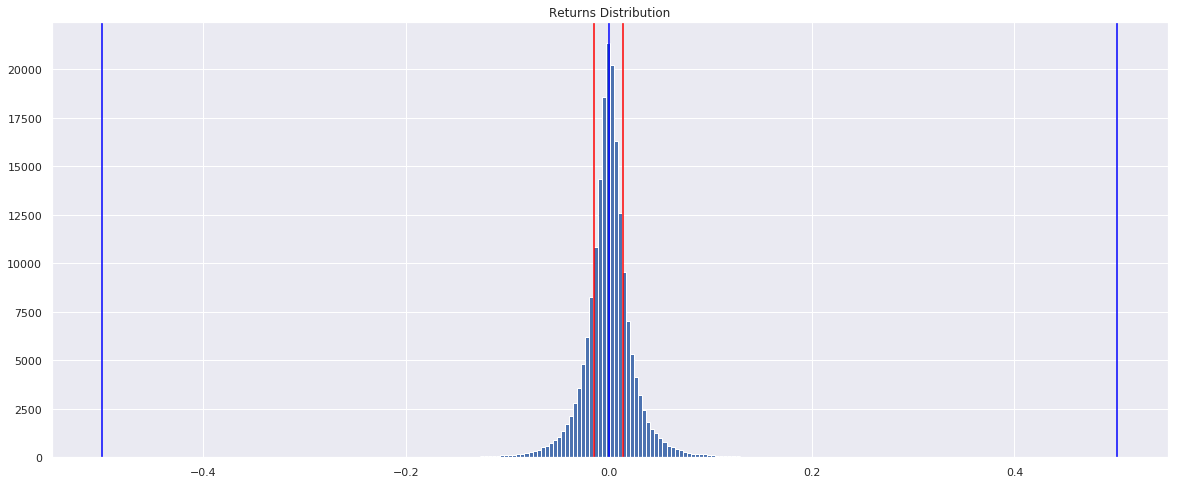

In [0]:
plt.figure(figsize=(20,8))
df.Returns.hist(bins=250)
plt.axvline(x=df.Returns.mean(), color='blue')
plt.axvline(x=df.Returns.min(), color='blue')
plt.axvline(x=df.Returns.max(), color='blue')
plt.axvline(x=df.Returns.quantile(.80), color='red')
plt.axvline(x=df.Returns.quantile(.20), color='red')
plt.title('Returns Distribution')
plt.show()

In [0]:
returns.head(10)

Datetime
2003-08-04 00:30:00         NaN
2003-08-04 01:00:00   -0.000027
2003-08-04 01:30:00   -0.000169
2003-08-04 02:00:00    0.000408
2003-08-04 02:30:00   -0.000550
2003-08-04 03:00:00    0.000178
2003-08-04 03:30:00    0.000080
2003-08-04 04:00:00    0.000497
2003-08-04 04:30:00    0.000142
2003-08-04 05:00:00    0.000027
Name: Close, dtype: float64

In [0]:
df.head(10)

,Date,Time,Open,High,Low,Close,Volume,Returns
Datetime,,,,,,,,
2003-08-04 00:30:00,2003.08.04,00:30,1.12709,1.12761,1.12640,1.12645,14212,-0.017534
2003-08-04 01:00:00,2003.08.04,01:00,1.12643,1.12675,1.12589,1.12642,15580,-0.000822
2003-08-04 01:30:00,2003.08.04,01:30,1.12644,1.12658,1.12572,1.12623,15492,-0.005138
2003-08-04 02:00:00,2003.08.04,02:00,1.12624,1.12733,1.12617,1.12669,13484,0.012396
2003-08-04 02:30:00,2003.08.04,02:30,1.12664,1.12700,1.12602,1.12607,14392,-0.016732
2003-08-04 03:00:00,2003.08.04,03:00,1.12616,1.12684,1.12592,1.12627,12608,0.005383
2003-08-04 03:30:00,2003.08.04,03:30,1.12625,1.12646,1.12564,1.12636,14848,0.002415
2003-08-04 04:00:00,2003.08.04,04:00,1.12660,1.12762,1.12659,1.12692,14576,0.015092
2003-08-04 04:30:00,2003.08.04,04:30,1.12690,1.12721,1.12629,1.12708,13888,0.004301


In [0]:
fielname = '/content/drive/My Drive/export/M30_all_EURUSD.csv'
df = pd.read_csv(filename)

In [0]:
normed = new_df

In [0]:
sequence_len = 30
reframed = series_to_supervised(normed.values, sequence_len, 1, feat_name=normed.columns)

# split into train and test sets
reframed = reframed.dropna()
x = reframed.values
y = df.iloc[sequence_len:]['Target'].values

split = int(len(x)*0.60)
x_train, x_tmp = x[:split], x[split:]
y_train, y_tmp = y[:split], y[split:]

half_split = int(len(x_tmp)*0.50)
x_test, x_final = x_tmp[:half_split], x_tmp[half_split:]
y_test, y_final = y_tmp[:half_split], y_tmp[half_split:]

In [0]:
print(normed.shape)
print(reframed.shape)

(193641, 22)
(193641, 682)


In [0]:
x.shape

(193611, 682)

In [0]:
y.shape

(193611,)

## Extract features from datetime

In [0]:
df_dt = pd.DataFrame({'date_time':df.index[reframed.index]})

In [0]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [0]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [0]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [0]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]